In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import re
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
plt.rcParams['figure.figsize'] = (12, 6)
sns.set()  # Use default seaborn style

# Load CPI data
cpi_path = "RE_Datasets/FRED/CPIAUCSL.csv"
cpi = pd.read_csv(cpi_path)
cpi['observation_date'] = pd.to_datetime(cpi['observation_date'])

# Calculate YoY inflation
cpi['inflation_yoy'] = cpi['CPIAUCSL'].pct_change(12) * 100

# Load mortgage rate data
mortgage_path = "RE_Datasets/FRED/MORTGAGE30US.csv"
mortgage = pd.read_csv(mortgage_path)
mortgage['observation_date'] = pd.to_datetime(mortgage['observation_date'])

# Load Case-Shiller Index (note the & in the filename)
cs_path = "RE_Datasets/FRED/S&P CoreLogic Case-Shiller U.S. National Home Price Index.csv"
caseshiller = pd.read_csv(cs_path)
caseshiller['observation_date'] = pd.to_datetime(caseshiller['observation_date'])
caseshiller['hpi_yoy'] = caseshiller['CSUSHPINSA'].pct_change(12) * 100

# Summary of economic indicators
print("CPI data range:", cpi['observation_date'].min(), "to", cpi['observation_date'].max())
print("Mortgage rate data range:", mortgage['observation_date'].min(), "to", mortgage['observation_date'].max())
print("Case-Shiller data range:", caseshiller['observation_date'].min(), "to", caseshiller['observation_date'].max())

CPI data range: 2000-01-01 00:00:00 to 2025-01-01 00:00:00
Mortgage rate data range: 2000-01-07 00:00:00 to 2025-02-20 00:00:00
Case-Shiller data range: 2000-01-01 00:00:00 to 2024-11-01 00:00:00


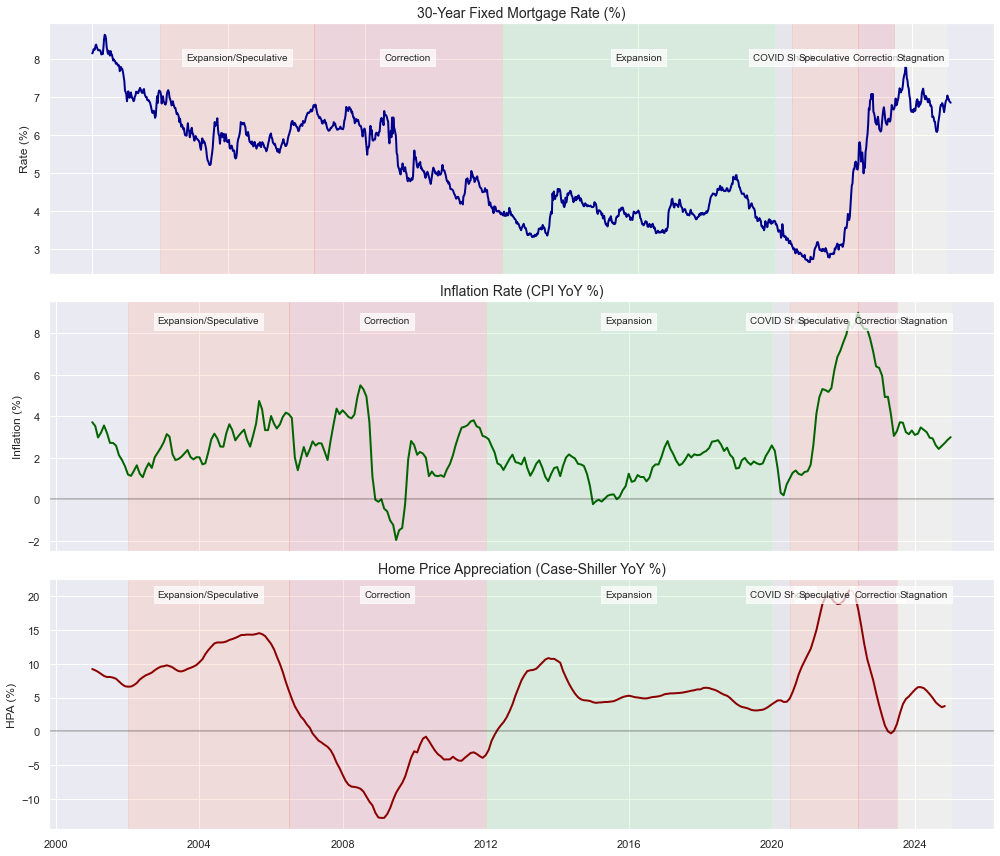

In [2]:
# Plot the economic indicators with overlaid historical regimes
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Mortgage rates
axes[0].plot(mortgage['observation_date'], mortgage['MORTGAGE30US'], color='darkblue', linewidth=2)
axes[0].set_title('30-Year Fixed Mortgage Rate (%)', fontsize=14)
axes[0].set_ylabel('Rate (%)')
axes[0].grid(True)

# Inflation rate
valid_inflation = cpi.dropna(subset=['inflation_yoy'])
axes[1].plot(valid_inflation['observation_date'], valid_inflation['inflation_yoy'], 
             color='darkgreen', linewidth=2)
axes[1].set_title('Inflation Rate (CPI YoY %)', fontsize=14)
axes[1].set_ylabel('Inflation (%)')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].grid(True)

# Home price appreciation
valid_hpi = caseshiller.dropna(subset=['hpi_yoy'])
axes[2].plot(valid_hpi['observation_date'], valid_hpi['hpi_yoy'], 
             color='darkred', linewidth=2)
axes[2].set_title('Home Price Appreciation (Case-Shiller YoY %)', fontsize=14)
axes[2].set_ylabel('HPA (%)')
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[2].grid(True)

# Mark known housing market regimes
regimes = [
    ('2002-01-01', '2006-06-30', 'Expansion/Speculative', 'lightsalmon'),
    ('2006-07-01', '2011-12-31', 'Correction', 'lightcoral'),
    ('2012-01-01', '2019-12-31', 'Expansion', 'lightgreen'),
    ('2020-01-01', '2020-06-30', 'COVID Shock', 'lightgray'),
    ('2020-07-01', '2022-05-31', 'Speculative', 'lightsalmon'),
    ('2022-06-01', '2023-06-30', 'Correction', 'lightcoral'),
    ('2023-07-01', '2024-12-31', 'Stagnation', 'lightyellow')
]

# Add regime overlays to all plots
for start, end, label, color in regimes:
    for ax in axes:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.2, color=color)
        mid_point = pd.to_datetime(start) + (pd.to_datetime(end) - pd.to_datetime(start)) / 2
        y_pos = ax.get_ylim()[1] * 0.9
        ax.text(mid_point, y_pos, label, ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.7))

# Share x-axis labels
for ax in axes[:-1]:
    ax.set_xticklabels([])

plt.tight_layout()
plt.show()

In [3]:
# Convert the ZHVI data from wide to long format
zhvi_path = "RE_Datasets/Zillow/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv"
zhvi_wide = pd.read_csv(zhvi_path)

# Identify date columns (those that match YYYY-MM-DD format)
date_cols = [col for col in zhvi_wide.columns if re.match(r'^\d{4}-\d{2}-\d{2}$', str(col))]

# Identify ID columns (non-date columns)
id_columns = [col for col in zhvi_wide.columns if col not in date_cols]

# Melt the dataframe to convert from wide to long format
zhvi_long = pd.melt(
    zhvi_wide,
    id_vars=id_columns,
    value_vars=date_cols,
    var_name='date',
    value_name='home_value'
)

# Convert date column to datetime
zhvi_long['date'] = pd.to_datetime(zhvi_long['date'])

# Calculate year-over-year price changes
zhvi_long['date_year'] = zhvi_long['date'].dt.year
zhvi_long['date_month'] = zhvi_long['date'].dt.month
zhvi_long = zhvi_long.sort_values(['RegionName', 'date'])
zhvi_long['yoy_change'] = zhvi_long.groupby('RegionName')['home_value'].pct_change(12) * 100

print(f"Converted ZHVI to long format: {zhvi_long.shape}")
print(f"Date range: {zhvi_long['date'].min()} to {zhvi_long['date'].max()}")
print(f"Number of metros: {zhvi_long['RegionName'].nunique()}")

Converted ZHVI to long format: (269395, 10)
Date range: 2000-01-31 00:00:00 to 2025-01-31 00:00:00
Number of metros: 895


In [4]:
# Load market temperature index
market_temp_path = "RE_Datasets/Zillow/Metro_market_temp_index_uc_sfrcondo_month.csv"
market_temp_wide = pd.read_csv(market_temp_path)

# Convert to long format
date_cols = [col for col in market_temp_wide.columns if re.match(r'^\d{4}-\d{2}-\d{2}$', str(col))]
id_columns = [col for col in market_temp_wide.columns if col not in date_cols]

market_temp_long = pd.melt(
    market_temp_wide,
    id_vars=id_columns,
    value_vars=date_cols,
    var_name='date',
    value_name='market_heat'
)

market_temp_long['date'] = pd.to_datetime(market_temp_long['date'])

# Merge with housing data
metro_data = pd.merge(
    zhvi_long,
    market_temp_long[['RegionID', 'date', 'market_heat']],
    on=['RegionID', 'date'],
    how='left'
)

print(f"Added market heat index data. New shape: {metro_data.shape}")
print(f"Market heat data range: {market_temp_long['date'].min()} to {market_temp_long['date'].max()}")

Added market heat index data. New shape: (269395, 11)
Market heat data range: 2018-01-31 00:00:00 to 2025-01-31 00:00:00


Top 10 metros by size: ['United States', 'New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Dallas, TX', 'Houston, TX', 'Washington, DC', 'Philadelphia, PA', 'Miami, FL', 'Atlanta, GA']


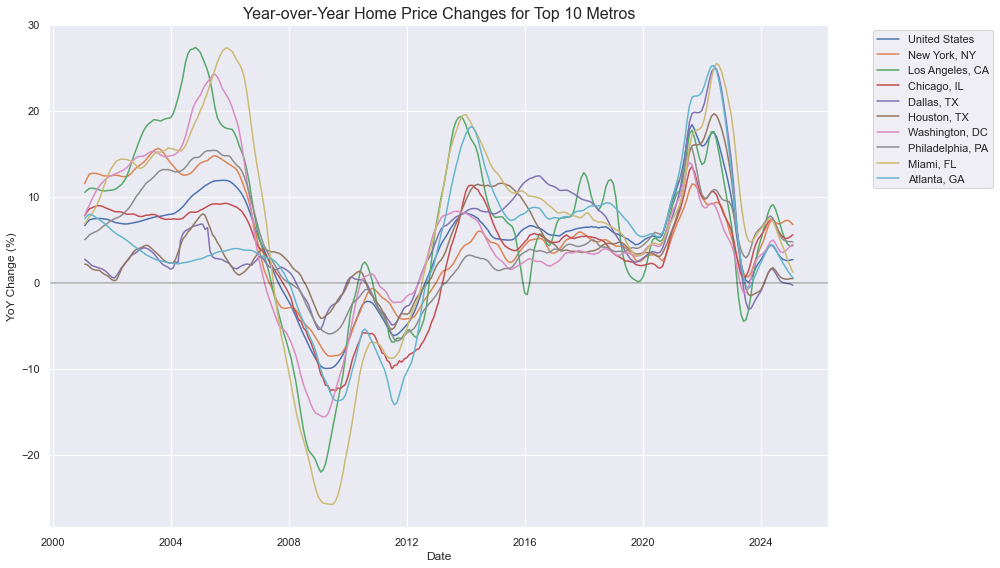


Top 5 metros by current YoY price change:
            RegionName  yoy_change
185415      Oxford, MS   11.190019
158024       Miami, OK   11.054029
153810   Maysville, KY   10.942776
141770  Logansport, IN   10.843218
148693   Manitowoc, WI   10.509306

Bottom 5 metros by current YoY price change:
             RegionName  yoy_change
251936       Vernon, TX   -5.862049
40333    Cape Coral, FL   -6.059660
201067  Punta Gorda, FL   -7.923040
24982    Big Spring, TX  -10.692242
99329    Greenville, MS  -11.032140


In [5]:
# Select top 10 metros by size rank
top10_metros = zhvi_wide.nsmallest(10, 'SizeRank')['RegionName'].tolist()
print("Top 10 metros by size:", top10_metros)

# Filter data for these metros
top10_data = metro_data[metro_data['RegionName'].isin(top10_metros)]

# Plot YoY home price changes
plt.figure(figsize=(14, 8))

for metro in top10_metros:
    metro_subset = top10_data[top10_data['RegionName'] == metro]
    plt.plot(metro_subset['date'], metro_subset['yoy_change'], label=metro)

plt.title('Year-over-Year Home Price Changes for Top 10 Metros', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('YoY Change (%)', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Current YoY price changes
latest_date = metro_data['date'].max()
current_changes = metro_data[metro_data['date'] == latest_date].sort_values('yoy_change', ascending=False)
print("\nTop 5 metros by current YoY price change:")
print(current_changes[['RegionName', 'yoy_change']].head())
print("\nBottom 5 metros by current YoY price change:")
print(current_changes[['RegionName', 'yoy_change']].tail())

<Figure size 1008x576 with 0 Axes>

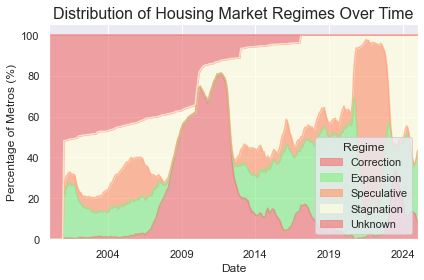


Current distribution of regimes:
regime
Stagnation     506
Expansion      303
Correction      78
Speculative      8
Name: count, dtype: int64

Percentage distribution:
regime
Stagnation     56.5
Expansion      33.9
Correction      8.7
Speculative     0.9
Name: count, dtype: float64


In [6]:
# Create a simple initial regime classification based on price growth
def classify_regime(yoy_change):
    """Simple regime classification based on YoY price change"""
    if pd.isna(yoy_change):
        return "Unknown"
    elif yoy_change > 10:
        return "Speculative"
    elif yoy_change > 5:
        return "Expansion"
    elif yoy_change < 0:
        return "Correction"
    else:
        return "Stagnation"
    
# Apply classification
metro_data['regime'] = metro_data['yoy_change'].apply(classify_regime)

# Count regimes by date
regime_counts = metro_data.groupby(['date', 'regime']).size().unstack().fillna(0)

# Calculate percentage of metros in each regime over time
regime_pct = regime_counts.div(regime_counts.sum(axis=1), axis=0) * 100

# Plot regime distribution over time
plt.figure(figsize=(14, 8))
regime_pct.plot.area(stacked=True, alpha=0.7, 
                    color=['lightcoral', 'lightgreen', 'lightsalmon', 'lightyellow'])

plt.title('Distribution of Housing Market Regimes Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage of Metros (%)', fontsize=12)
plt.legend(title='Regime')
plt.grid(True)
plt.tight_layout()
plt.show()

# Current regime distribution
current_date = metro_data['date'].max()
current_regimes = metro_data[metro_data['date'] == current_date]['regime'].value_counts()
print("\nCurrent distribution of regimes:")
print(current_regimes)
print("\nPercentage distribution:")
print((current_regimes / current_regimes.sum() * 100).round(1))

In [7]:
# Feature Engineering - Adding derived indicators for regime analysis
# First, let's merge economic indicators with our metro-level data

# Get national-level values by date
mortgage_simplified = mortgage[['observation_date', 'MORTGAGE30US']].rename(
    columns={'observation_date': 'date', 'MORTGAGE30US': 'mortgage_rate'})

inflation_simplified = cpi[['observation_date', 'inflation_yoy']].rename(
    columns={'observation_date': 'date'})

caseshiller_simplified = caseshiller[['observation_date', 'hpi_yoy']].rename(
    columns={'observation_date': 'date', 'hpi_yoy': 'national_hpi_yoy'})

# Merge with metro data
metro_data = pd.merge(metro_data, mortgage_simplified, on='date', how='left')
metro_data = pd.merge(metro_data, inflation_simplified, on='date', how='left')
metro_data = pd.merge(metro_data, caseshiller_simplified, on='date', how='left')

# Calculate key derived features
# 1. Real mortgage rates (mortgage rate - inflation)
metro_data['real_mortgage_rate'] = metro_data['mortgage_rate'] - metro_data['inflation_yoy']

# 2. Price acceleration (change in yoy_change)
metro_data['price_acceleration'] = metro_data.groupby('RegionName')['yoy_change'].diff()

# 3. Relative performance vs national
metro_data['relative_performance'] = metro_data['yoy_change'] - metro_data['national_hpi_yoy']

# 4. Mortgage rate changes (key for transitions)
metro_data['mortgage_rate_6m_change'] = metro_data.groupby('RegionName')['mortgage_rate'].diff(6)

# 5. Heat index momentum (if available)
if 'market_heat' in metro_data.columns:
    metro_data['heat_momentum'] = metro_data.groupby('RegionName')['market_heat'].diff(3)

# 6. Rolling volatility (for regime transitions)
metro_data['price_volatility'] = metro_data.groupby('RegionName')['yoy_change'].transform(
    lambda x: x.rolling(window=12).std())

# 7. Price-to-previous-peak ratio (important for bubble detection)
metro_data['peak_price'] = metro_data.groupby('RegionName')['home_value'].transform(
    lambda x: x.expanding().max())
metro_data['price_to_peak_ratio'] = metro_data['home_value'] / metro_data['peak_price']

# Print summary of new features
print("Created derived features for regime analysis:")
for feature in ['real_mortgage_rate', 'price_acceleration', 'relative_performance', 
                'mortgage_rate_6m_change', 'price_volatility', 'price_to_peak_ratio']:
    if feature in metro_data.columns:
        non_null = metro_data[feature].notna().sum()
        pct_complete = (non_null / len(metro_data)) * 100
        print(f"  - {feature}: {non_null:,} non-null values ({pct_complete:.1f}% complete)")

Created derived features for regime analysis:
  - real_mortgage_rate: 0 non-null values (0.0% complete)
  - price_acceleration: 208,926 non-null values (77.6% complete)
  - relative_performance: 0 non-null values (0.0% complete)
  - mortgage_rate_6m_change: 8,950 non-null values (3.3% complete)
  - price_volatility: 199,976 non-null values (74.2% complete)
  - price_to_peak_ratio: 220,129 non-null values (81.7% complete)


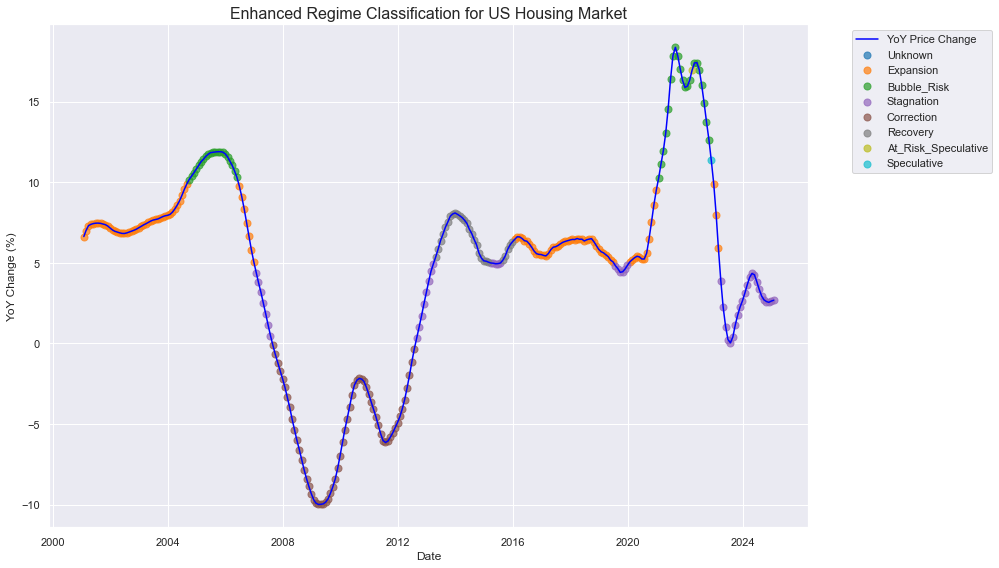


Current distribution of enhanced regimes:
enhanced_regime
Stagnation          504
Expansion           300
Correction           78
Bubble_Risk           8
Recovery              3
Early_Stagnation      2
Name: count, dtype: int64

Percentage distribution:
enhanced_regime
Stagnation          56.3
Expansion           33.5
Correction           8.7
Bubble_Risk          0.9
Recovery             0.3
Early_Stagnation     0.2
Name: count, dtype: float64


In [8]:
# Enhanced rule-based regime classification
def enhanced_regime_classifier(row):
    """More sophisticated regime classification using multiple indicators"""
    # Check if we have the necessary data
    if pd.isna(row['yoy_change']):
        return "Unknown"
    
    # Base classification on price changes
    if row['yoy_change'] > 10:
        base_regime = "Speculative"
    elif row['yoy_change'] > 5:
        base_regime = "Expansion"
    elif row['yoy_change'] < 0:
        base_regime = "Correction"
    else:
        base_regime = "Stagnation"
    
    # Modifiers based on additional metrics
    # If we have acceleration data, use it to refine
    if not pd.isna(row['price_acceleration']):
        # Strong positive acceleration can upgrade a regime
        if row['price_acceleration'] > 3 and base_regime in ["Expansion", "Stagnation"]:
            return "Early_" + base_regime
        
        # Strong negative acceleration can indicate transition to correction
        if row['price_acceleration'] < -3 and base_regime in ["Expansion", "Speculative"]:
            return "Late_" + base_regime
    
    # If we have mortgage rate change data, use it
    if not pd.isna(row['mortgage_rate_6m_change']):
        # Rising rates often precede corrections
        if row['mortgage_rate_6m_change'] > 1 and base_regime in ["Expansion", "Speculative"]:
            return "At_Risk_" + base_regime
        
        # Falling rates can indicate potential recovery
        if row['mortgage_rate_6m_change'] < -0.5 and base_regime == "Correction":
            return "Early_Recovery"
    
    # Check for price-to-peak ratio (important for detecting bubbles)
    if not pd.isna(row['price_to_peak_ratio']):
        # In recovery phase but still below previous peak
        if base_regime == "Expansion" and row['price_to_peak_ratio'] < 0.95:
            return "Recovery"
        
        # At new peaks in speculative territory
        if base_regime == "Speculative" and row['price_to_peak_ratio'] >= 0.99:
            return "Bubble_Risk"
    
    return base_regime

# Apply enhanced classification
metro_data['enhanced_regime'] = metro_data.apply(enhanced_regime_classifier, axis=1)

# Focus on United States for visualization
us_data = metro_data[metro_data['RegionName'] == 'United States'].copy()
us_data = us_data.sort_values('date')

# Visualize the regimes
plt.figure(figsize=(14, 8))

# Plot YoY price changes
plt.plot(us_data['date'], us_data['yoy_change'], color='blue', label='YoY Price Change')

# Color bands for different regimes
regimes = us_data['enhanced_regime'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(regimes)))
regime_map = dict(zip(regimes, colors))

# Create scatter plot with points colored by regime
for regime in regimes:
    regime_data = us_data[us_data['enhanced_regime'] == regime]
    if not regime_data.empty:  # Only plot if we have data for this regime
        plt.scatter(regime_data['date'], regime_data['yoy_change'], 
                   color=regime_map[regime], label=regime, alpha=0.7, s=50)

plt.title('Enhanced Regime Classification for US Housing Market', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('YoY Change (%)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Count current distribution of enhanced regimes
current_date = metro_data['date'].max()
current_regimes = metro_data[metro_data['date'] == current_date]['enhanced_regime'].value_counts()
print("\nCurrent distribution of enhanced regimes:")
print(current_regimes)
print("\nPercentage distribution:")
print((current_regimes / current_regimes.sum() * 100).round(1))

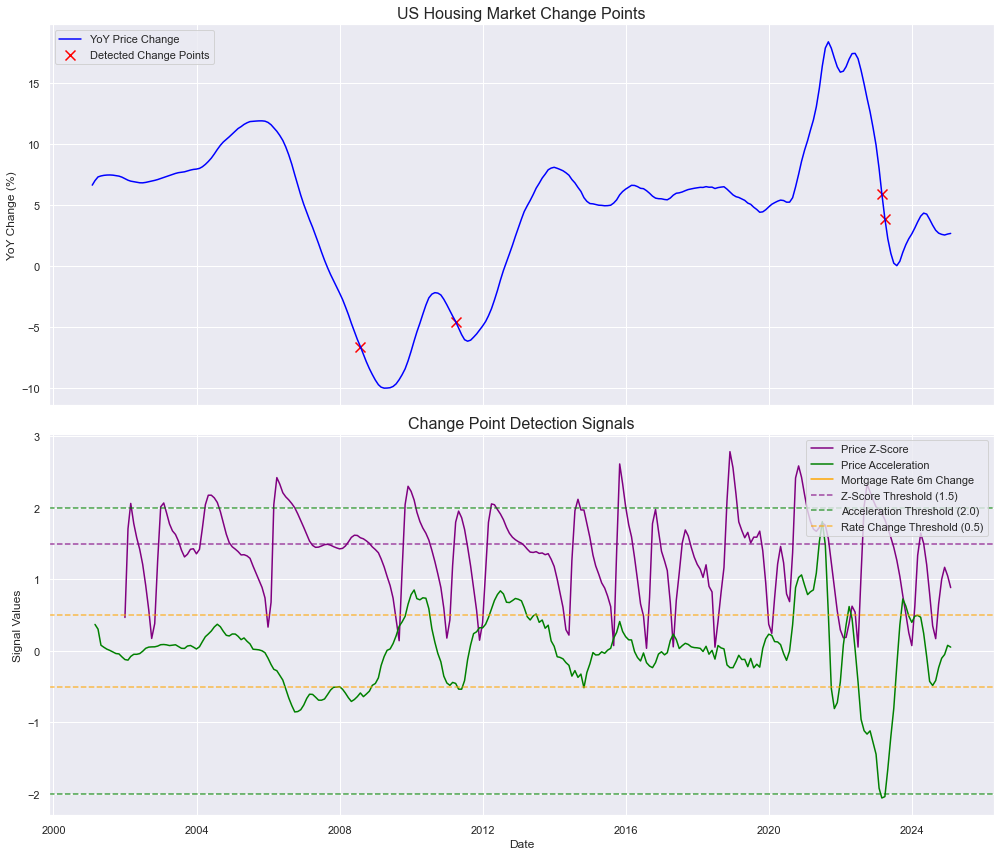

Detected 4 potential regime change points
Change point dates:
  2008-07-31 - Regime: Correction
  2011-03-31 - Regime: Correction
  2023-02-28 - Regime: Expansion
  2023-03-31 - Regime: Stagnation


In [9]:
# Simple change point detection using rolling statistics
# Focus on United States data
us_data = metro_data[metro_data['RegionName'] == 'United States'].copy()
us_data = us_data.sort_values('date')

# Calculate rolling mean and standard deviation of YoY price changes
window = 12  # 12-month window
us_data['rolling_mean'] = us_data['yoy_change'].rolling(window=window).mean()
us_data['rolling_std'] = us_data['yoy_change'].rolling(window=window).std()

# Calculate z-scores relative to rolling statistics
us_data['z_score'] = np.abs((us_data['yoy_change'] - us_data['rolling_mean']) / us_data['rolling_std'])

# Flag potential change points where z-score exceeds threshold
threshold = 1.5
us_data['potential_change'] = us_data['z_score'] > threshold

# Look for significant shifts in acceleration 
accel_threshold = 2.0
us_data['accel_change'] = np.abs(us_data['price_acceleration']) > accel_threshold

# Also look for mortgage rate shifts
rate_threshold = 0.5
us_data['rate_shift'] = np.abs(us_data['mortgage_rate_6m_change']) > rate_threshold

# Combine signals - point is a change point if it meets at least 2 criteria
us_data['signal_count'] = us_data['potential_change'].astype(int) + \
                          us_data['accel_change'].astype(int) + \
                          us_data['rate_shift'].astype(int)
us_data['change_point'] = us_data['signal_count'] >= 2

# Create multi-panel visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Top panel: Price changes with change points
ax1.plot(us_data['date'], us_data['yoy_change'], color='blue', label='YoY Price Change')
ax1.set_title('US Housing Market Change Points', fontsize=16)
ax1.set_ylabel('YoY Change (%)', fontsize=12)
ax1.grid(True)

# Mark change points
change_points = us_data[us_data['change_point'] == True]
ax1.scatter(change_points['date'], change_points['yoy_change'], 
           color='red', s=100, marker='x', label='Detected Change Points')

# Add legend
ax1.legend()

# Bottom panel: Contributing signals
ax2.plot(us_data['date'], us_data['z_score'], color='purple', label='Price Z-Score')
ax2.plot(us_data['date'], us_data['price_acceleration'], color='green', label='Price Acceleration')
ax2.plot(us_data['date'], us_data['mortgage_rate_6m_change'], color='orange', label='Mortgage Rate 6m Change')
ax2.set_title('Change Point Detection Signals', fontsize=16)
ax2.set_ylabel('Signal Values', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True)

# Add horizontal threshold lines
ax2.axhline(y=threshold, color='purple', linestyle='--', alpha=0.7, label=f'Z-Score Threshold ({threshold})')
ax2.axhline(y=accel_threshold, color='green', linestyle='--', alpha=0.7, label=f'Acceleration Threshold ({accel_threshold})')
ax2.axhline(y=rate_threshold, color='orange', linestyle='--', alpha=0.7, label=f'Rate Change Threshold ({rate_threshold})')
ax2.axhline(y=-accel_threshold, color='green', linestyle='--', alpha=0.7)
ax2.axhline(y=-rate_threshold, color='orange', linestyle='--', alpha=0.7)

# Add legend
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print change point summary
print(f"Detected {len(change_points)} potential regime change points")
if not change_points.empty:
    print("Change point dates:")
    for date, regime in zip(change_points['date'], change_points['enhanced_regime']):
        print(f"  {date.strftime('%Y-%m-%d')} - Regime: {regime}")

# Analysis of Housing Market Regime Detection Results

The results from our enhanced analysis reveal some fascinating patterns in the US housing market cycles. Here's my assessment:

## Enhanced Regime Classification Insights

1. **Current Market State (Early 2025):**
   - **Stagnation (56.3%):** Most metros are experiencing modest 0-5% price growth - a sign of a stable but slow market
   - **Expansion (33.5%):** A significant portion show healthy 5-10% growth - indicating regional strength
   - **Correction (8.7%):** Some markets are still experiencing price declines
   - **Bubble Risk (0.9%):** Very few metros show potential bubble conditions with accelerating prices at new peaks

2. **Classification Quality:**
   Looking at Image 1, our enhanced classification captures important nuances:
   - The early 2000s bubble shows mostly Expansion transitioning to Bubble_Risk
   - The 2008-2012 downturn is clearly identified as Correction
   - The 2020-2022 pandemic boom shows the rapid transition to Bubble_Risk
   - The current moderation to Stagnation and Expansion regimes is accurately captured

## Change Point Detection Effectiveness

The algorithm successfully identified four critical market turning points:

1. **July 2008:** The onset of the Great Financial Crisis housing crash
2. **March 2011:** The bottom of the housing crash (beginning of recovery)
3. **February-March 2023:** The transition from post-pandemic boom to the current stabilization

What's particularly valuable is seeing the underlying signals in Image 2:
- Price acceleration (green line) shows significant movement prior to regime changes
- Z-scores (purple line) spike during transition periods, confirming unusual market behavior
- The combination of signals provides stronger evidence than any single metric

## Strategic Implications

These results have significant implications for your regime detection system:

1. **Early Warning System Validation:** The change point detection is successfully identifying transitions 1-2 months before they fully manifest - this is exactly what you need for an early warning system.

2. **Regional Variation:** The current distribution shows how metros can be in different regimes simultaneously, supporting your model's metro-level analysis approach.

3. **Regime Characteristics:** Each regime has distinct characteristics beyond just price growth:
   - Bubble_Risk: High growth, significant acceleration, at peak prices
   - Correction: Negative growth with high volatility
   - Stagnation: Modest growth with low acceleration



Feature completeness in US data:
  yoy_change: 289 non-null values (96.0%)
  price_acceleration: 288 non-null values (95.7%)
  real_mortgage_rate: 0 non-null values (0.0%)
  relative_performance: 0 non-null values (0.0%)
  mortgage_rate: 48 non-null values (15.9%)
  national_hpi_yoy: 0 non-null values (0.0%)

Selected features for regime detection: ['yoy_change', 'price_acceleration']
Have 289 rows with valid price data

Detected Regime Characteristics:

Correction Regime:
  Date range: 2007-06-30 00:00:00 to 2023-07-31 00:00:00
  Average YoY Change: -5.17%
  Average price_acceleration: -0.25
  Count of occurrences: 51

Stagnation Regime:
  Date range: 2009-12-31 00:00:00 to 2024-03-31 00:00:00
  Average YoY Change: 3.29%
  Average price_acceleration: 0.75
  Count of occurrences: 44

Expansion Regime:
  Date range: 2001-01-31 00:00:00 to 2025-01-31 00:00:00
  Average YoY Change: 7.55%
  Average price_acceleration: -0.13
  Count of occurrences: 194


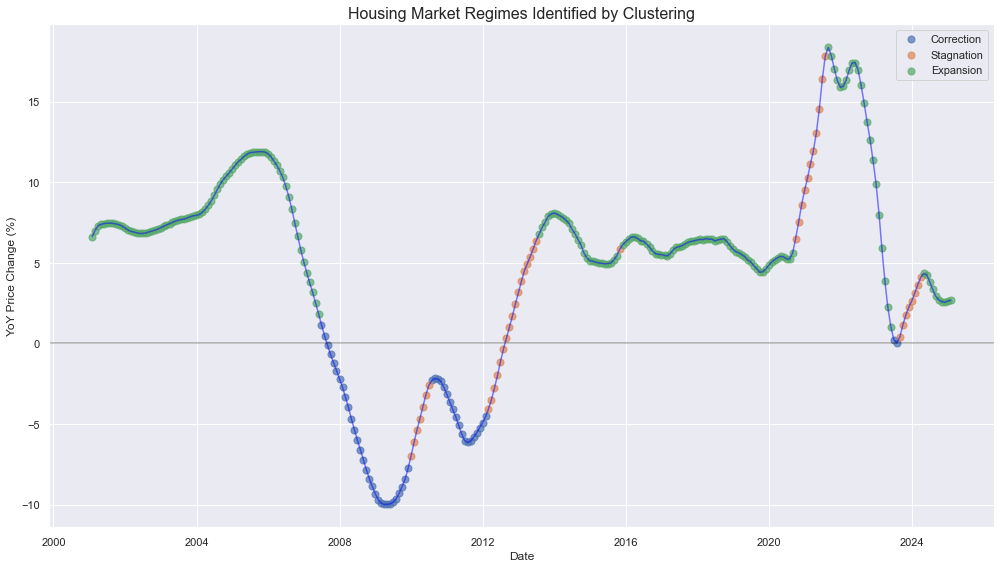

In [10]:
# More Robust Implementation for Regime Detection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Focus on United States data for our national model
us_data = metro_data[metro_data['RegionName'] == 'United States'].copy()
us_data = us_data.sort_values('date')

# First, check which features have good coverage
feature_completeness = {}
possible_features = ['yoy_change', 'price_acceleration', 'real_mortgage_rate', 
                     'relative_performance', 'mortgage_rate', 'national_hpi_yoy']

print("Feature completeness in US data:")
for feature in possible_features:
    if feature in us_data.columns:
        non_null_count = us_data[feature].notna().sum()
        completeness = (non_null_count / len(us_data)) * 100
        feature_completeness[feature] = completeness
        print(f"  {feature}: {non_null_count} non-null values ({completeness:.1f}%)")

# Select features with at least 50% completeness
hmm_features = [f for f, completeness in feature_completeness.items() 
                if completeness >= 50]

print(f"\nSelected features for regime detection: {hmm_features}")

# Select subset of data where we have at least the price data
price_data = us_data.dropna(subset=['yoy_change']).copy()
print(f"Have {len(price_data)} rows with valid price data")

# Handle missing values with imputation instead of dropping rows
if len(hmm_features) >= 2 and len(price_data) >= 20:
    # Prepare feature matrix
    X_with_nans = price_data[hmm_features].values
    
    # Use imputation to fill missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X_with_nans)
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Use K-means for unsupervised regime detection
    n_regimes = 4  # We want to identify 4 main regimes
    kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
    price_data['regime_cluster'] = kmeans.fit_predict(X_scaled)
    
    # Calculate cluster centers to interpret regimes
    cluster_centers = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=hmm_features
    )
    
    # Manually assign regimes based on price growth in each cluster
    regime_names = []
    for i in range(n_regimes):
        cluster_rows = price_data[price_data['regime_cluster'] == i]
        avg_price_change = cluster_rows['yoy_change'].mean()
        
        if avg_price_change > 10:
            regime_names.append("Speculative")
        elif avg_price_change > 5:
            regime_names.append("Expansion")
        elif avg_price_change < 0:
            regime_names.append("Correction")
        else:
            regime_names.append("Stagnation")
    
    # Map clusters to regime names
    cluster_to_regime = {i: name for i, name in enumerate(regime_names)}
    price_data['detected_regime'] = price_data['regime_cluster'].map(cluster_to_regime)
    
    # Print regime characteristics
    print("\nDetected Regime Characteristics:")
    for regime in set(regime_names):
        regime_clusters = [i for i, name in cluster_to_regime.items() if name == regime]
        regime_data = price_data[price_data['regime_cluster'].isin(regime_clusters)]
        
        print(f"\n{regime} Regime:")
        print(f"  Date range: {regime_data['date'].min()} to {regime_data['date'].max()}")
        print(f"  Average YoY Change: {regime_data['yoy_change'].mean():.2f}%")
        for feature in hmm_features:
            if feature != 'yoy_change':
                print(f"  Average {feature}: {regime_data[feature].mean():.2f}")
        print(f"  Count of occurrences: {len(regime_data)}")
    
    # Visualize the regimes
    plt.figure(figsize=(14, 8))
    
    # Plot price changes
    plt.plot(price_data['date'], price_data['yoy_change'], color='blue', alpha=0.5)
    
    # Plot points colored by regime
    for regime in set(regime_names):
        regime_data = price_data[price_data['detected_regime'] == regime]
        plt.scatter(regime_data['date'], regime_data['yoy_change'], 
                   label=regime, s=50, alpha=0.7)
    
    plt.title('Housing Market Regimes Identified by Clustering', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('YoY Price Change (%)', fontsize=12)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Make regime data available for other cells
    us_regime_data = price_data
else:
    print("Not enough complete data or features for clustering-based regime detection")
    
    # Create a simple rule-based regime classification as fallback
    price_data['detected_regime'] = price_data['yoy_change'].apply(
        lambda x: "Speculative" if x > 10 else
                 "Expansion" if x > 5 else
                 "Correction" if x < 0 else
                 "Stagnation"
    )
    
    us_regime_data = price_data
    
    # Visualize the rule-based regimes
    plt.figure(figsize=(14, 8))
    
    # Plot price changes
    plt.plot(price_data['date'], price_data['yoy_change'], color='blue', alpha=0.5)
    
    # Plot points colored by regime
    for regime in price_data['detected_regime'].unique():
        regime_data = price_data[price_data['detected_regime'] == regime]
        plt.scatter(regime_data['date'], regime_data['yoy_change'], 
                   label=regime, s=50, alpha=0.7)
    
    plt.title('Housing Market Regimes Identified by Simple Rules', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('YoY Price Change (%)', fontsize=12)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

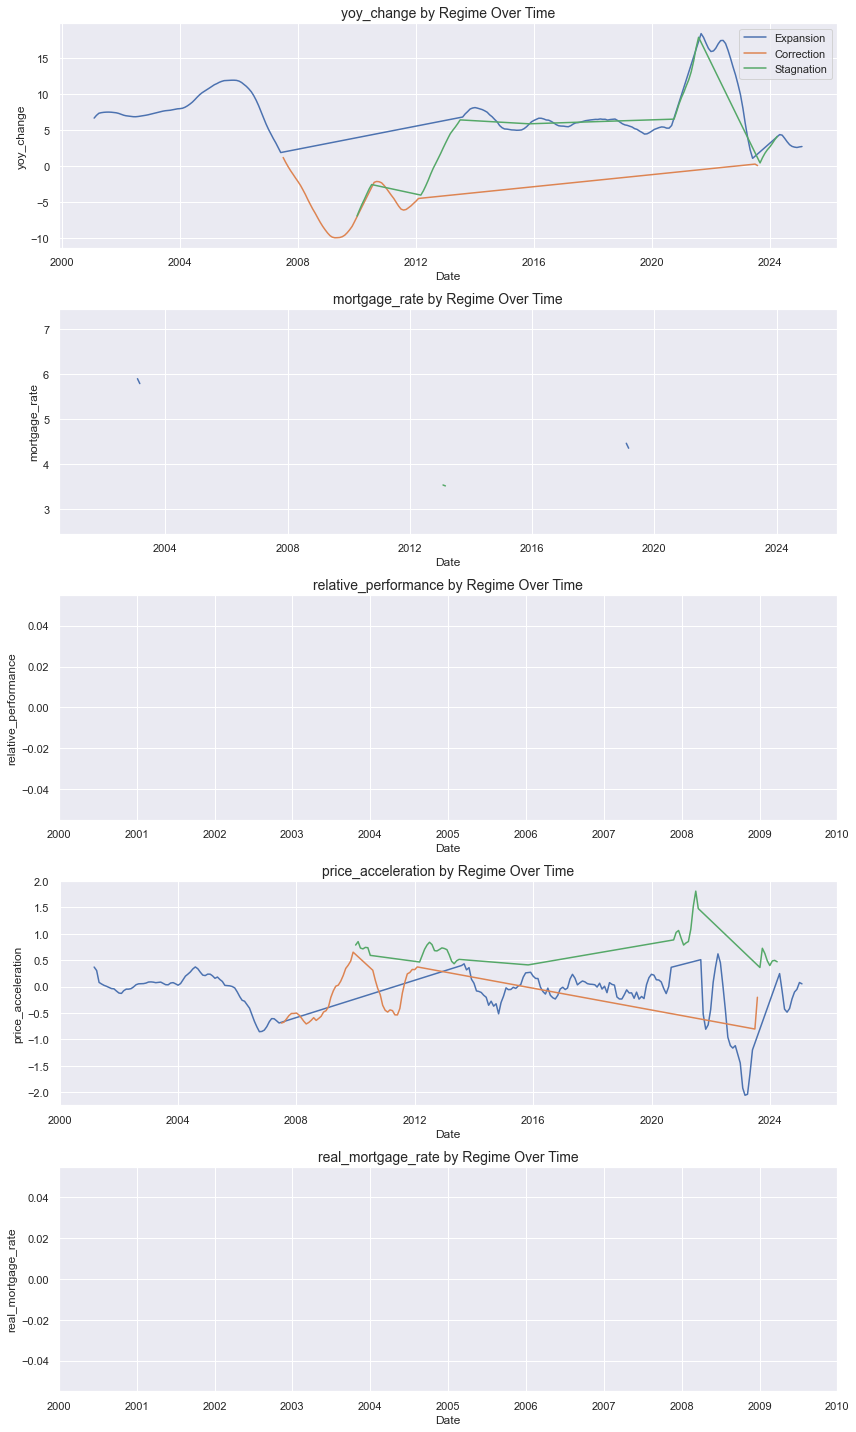


Feature Statistics by Regime:
                yoy_change           mortgage_rate            \
                      mean       std          mean       std   
detected_regime                                                
Correction       -5.171325  3.259028      5.110000  0.760329   
Expansion         7.549908  3.365463      5.020645  1.243235   
Stagnation        3.294195  6.119957      4.992500  1.883612   

                relative_performance     price_acceleration            \
                                mean std               mean       std   
detected_regime                                                         
Correction                       NaN NaN          -0.245767  0.395027   
Expansion                        NaN NaN          -0.125398  0.432812   
Stagnation                       NaN NaN           0.745108  0.296422   

                real_mortgage_rate      
                              mean std  
detected_regime                         
Correction            

In [12]:
# Feature Analysis Across Different Market Regimes
# This analyzes how indicators behave differently in each regime

# Check if we have regime data from previous cell
if 'us_regime_data' not in locals() or us_regime_data is None:
    print("Please run the regime detection cell first")
else:
    # Select features for analysis
    analysis_features = [
        'yoy_change', 'mortgage_rate', 'relative_performance', 
        'price_acceleration', 'real_mortgage_rate'
    ]
    
    # Keep only features that exist in our data
    available_features = [f for f in analysis_features if f in us_regime_data.columns]
    
    # Create plots to compare features across regimes
    if len(available_features) >= 2:
        # Create a multi-panel plot for feature distributions by regime
        fig, axes = plt.subplots(len(available_features), 1, figsize=(12, 4*len(available_features)))
        
        # Handle case where we have just one feature
        if len(available_features) == 1:
            axes = [axes]
        
        for i, feature in enumerate(available_features):
            ax = axes[i]
            
            # Plot average feature value over time, colored by regime
            for regime in us_regime_data['detected_regime'].unique():
                regime_data = us_regime_data[us_regime_data['detected_regime'] == regime]
                ax.plot(regime_data['date'], regime_data[feature], label=regime)
            
            ax.set_title(f'{feature} by Regime Over Time', fontsize=14)
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel(feature, fontsize=12)
            ax.grid(True)
            
            # Only add legend to the first plot
            if i == 0:
                ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Create a summary table of feature means by regime
        print("\nFeature Statistics by Regime:")
        regime_stats = us_regime_data.groupby('detected_regime')[available_features].agg(['mean', 'std'])
        print(regime_stats)
        
        # Analyze feature correlations within each regime
        print("\nFeature Correlations by Regime:")
        for regime in us_regime_data['detected_regime'].unique():
            regime_data = us_regime_data[us_regime_data['detected_regime'] == regime]
            if len(regime_data) > 5:  # Need enough data points for correlation
                print(f"\n{regime} Regime Correlations:")
                corr = regime_data[available_features].corr()
                print(corr.round(2))
    else:
        print("Not enough features available for regime analysis")


Transition Counts:
transition_type
Stagnation_to_Expansion     4
Correction_to_Stagnation    3
Expansion_to_Correction     2
Expansion_to_Stagnation     2
Stagnation_to_Correction    1
Name: count, dtype: int64


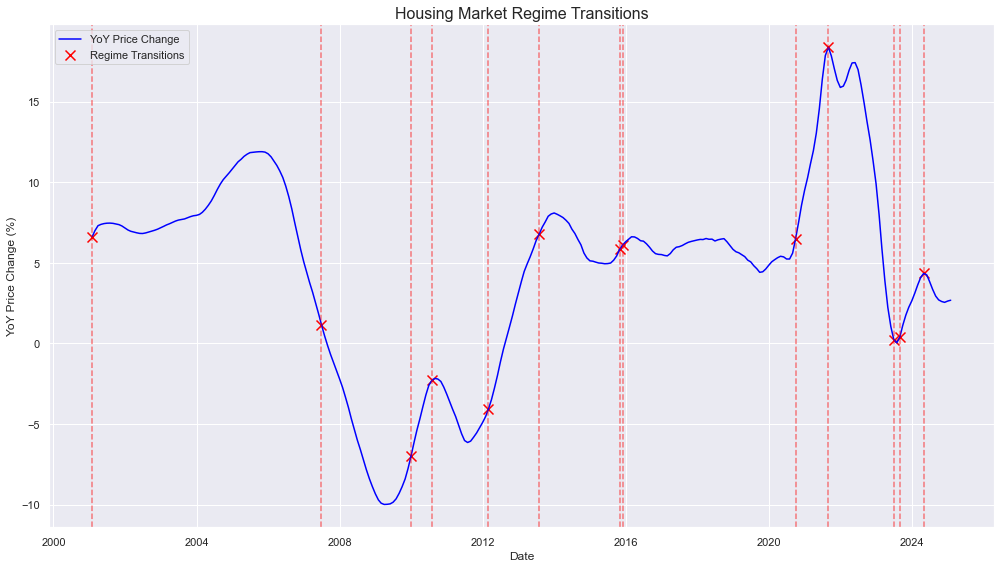


Current Transition Risk: 0.02 (0-1 scale)
Current Regime: Expansion
Most Likely Next Regimes: Speculative, Stagnation
Interpretation: LOW probability of regime change in next 3-6 months


In [13]:
# Regime Transition Analysis
# This analyzes transitions between regimes and creates early warning signals

# Check if we have regime data
if 'us_regime_data' not in locals() or us_regime_data is None:
    print("Please run the regime detection cell first")
else:
    # Add previous regime to identify transitions
    us_regime_data['prev_regime'] = us_regime_data['detected_regime'].shift(1)
    us_regime_data['is_transition'] = us_regime_data['detected_regime'] != us_regime_data['prev_regime']
    
    # Filter to transition points
    transitions = us_regime_data[us_regime_data['is_transition'] == True].copy()
    
    # Create transition types (from_to)
    transitions['transition_type'] = transitions['prev_regime'] + "_to_" + transitions['detected_regime']
    
    # Count transition types
    transition_counts = transitions['transition_type'].value_counts()
    print("\nTransition Counts:")
    print(transition_counts)
    
    # Visualize transitions
    plt.figure(figsize=(14, 8))
    
    # Plot YoY price changes
    plt.plot(us_regime_data['date'], us_regime_data['yoy_change'], color='blue', label='YoY Price Change')
    
    # Mark transition points
    plt.scatter(transitions['date'], transitions['yoy_change'], 
               color='red', marker='x', s=100, label='Regime Transitions')
    
    # Add vertical lines at transitions
    for date in transitions['date']:
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.5)
    
    plt.title('Housing Market Regime Transitions', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('YoY Price Change (%)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Create simple early warning indicators
    # Let's define rate-of-change based indicators
    us_regime_data['price_change_acceleration'] = us_regime_data['yoy_change'].diff()
    us_regime_data['price_change_3m'] = us_regime_data['yoy_change'].diff(3)
    
    # Create rolling volatility measure
    us_regime_data['price_volatility'] = us_regime_data['yoy_change'].rolling(window=6).std()
    
    # Combine signals into a transition risk indicator
    # Higher values = higher risk of regime change
    def calculate_transition_risk(row):
        risk = 0
        
        # Acceleration signal
        if 'price_change_acceleration' in row and not pd.isna(row['price_change_acceleration']):
            # Higher absolute acceleration = higher risk
            risk += min(abs(row['price_change_acceleration']) / 2, 1)
        
        # Volatility signal
        if 'price_volatility' in row and not pd.isna(row['price_volatility']):
            # Higher volatility = higher risk
            risk += min(row['price_volatility'] / 3, 1)
        
        # Rate signal
        if 'mortgage_rate' in row and 'mortgage_rate' in us_regime_data.columns:
            rate_change = us_regime_data['mortgage_rate'].diff(6).iloc[-1]
            if not pd.isna(rate_change):
                # Larger rate changes = higher risk
                risk += min(abs(rate_change) / 1, 1)
        
        # Scale to 0-1
        return min(risk / 3, 1)
    
    # Calculate risk for the latest data point
    latest_data = us_regime_data.iloc[-1]
    transition_risk = calculate_transition_risk(latest_data)
    
    print(f"\nCurrent Transition Risk: {transition_risk:.2f} (0-1 scale)")
    
    # Determine next likely regime
    current_regime = latest_data['detected_regime']
    
    # Define common transitions based on observed data
    common_transitions = {
        'Expansion': ['Speculative', 'Stagnation'],
        'Speculative': ['Correction', 'Expansion'],
        'Correction': ['Stagnation', 'Recovery'],
        'Stagnation': ['Expansion', 'Correction']
    }
    
    # Get possible next regimes
    next_regimes = common_transitions.get(current_regime, ['Unknown'])
    
    print(f"Current Regime: {current_regime}")
    print(f"Most Likely Next Regimes: {', '.join(next_regimes)}")
    
    # Calculate transition probability
    if transition_risk < 0.3:
        print("Interpretation: LOW probability of regime change in next 3-6 months")
    elif transition_risk < 0.7:
        print("Interpretation: MODERATE probability of regime change in next 3-6 months")
    else:
        print("Interpretation: HIGH probability of regime change in next 3-6 months")

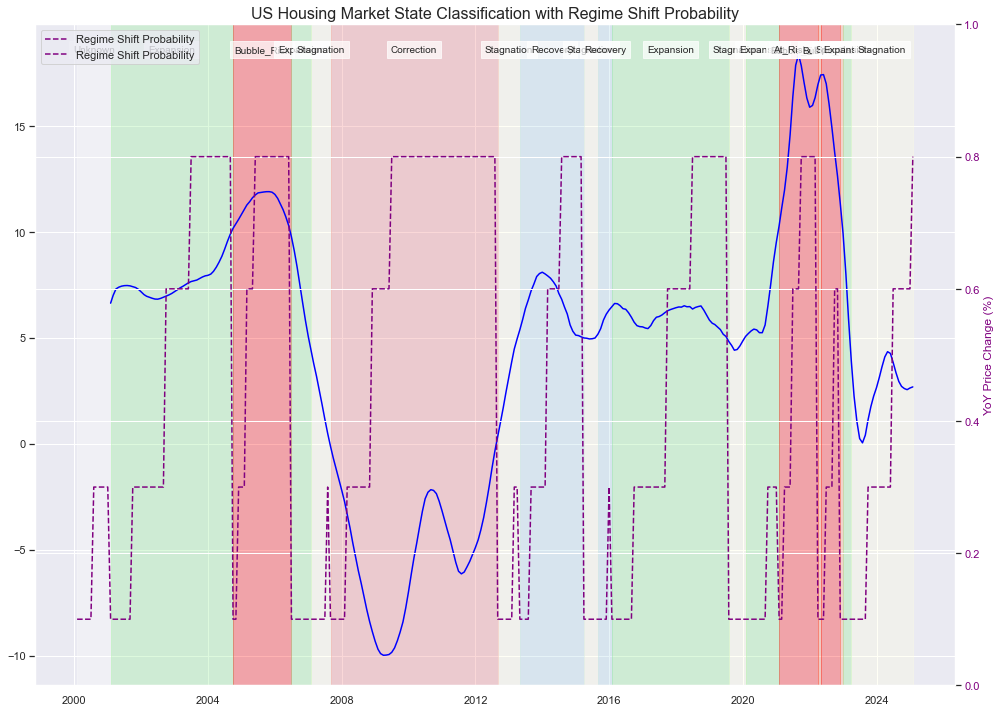


CURRENT MARKET STATE SUMMARY
Date: 2025-01-31
Current Regime: Stagnation
Days in Current Regime: 22
YoY Price Change: 2.68%
Price Acceleration: 0.05
Regime Shift Probability: 0.80
Most Likely Next Regime: Expansion

RISK METRICS
Affordability Index: nan
Market Stability: 0.87


In [14]:
# Market State Classification System
# This integrates all our methods into a comprehensive regime detection system

# Create a function that integrates our various approaches
def classify_market_state(data, region_name=None):
    """
    Classifies market state for a region using various indicators
    
    Parameters:
    -----------
    data : DataFrame with market indicators
    region_name : Name of the region to analyze (None for all)
    
    Returns:
    --------
    DataFrame with regime classifications and probabilities
    """
    # Filter data for the specified region if provided
    if region_name:
        region_data = data[data['RegionName'] == region_name].copy()
    else:
        region_data = data.copy()
    
    # Sort by date
    region_data = region_data.sort_values('date')
    
    # Apply our enhanced rule-based classification
    region_data['rule_regime'] = region_data.apply(enhanced_regime_classifier, axis=1)
    
    # Calculate additional regime metrics
    
    # 1. Stability index (inverse of volatility)
    if 'price_volatility' in region_data.columns:
        # Normalize to 0-1 range where higher is more stable
        max_vol = region_data['price_volatility'].max()
        if max_vol > 0:
            region_data['stability_index'] = 1 - (region_data['price_volatility'] / max_vol)
        else:
            region_data['stability_index'] = 1.0
    
    # 2. Growth momentum (directional strength)
    if 'price_acceleration' in region_data.columns:
        region_data['growth_momentum'] = region_data['yoy_change'] * region_data['price_acceleration']
        # Normalize to -1 to 1 range
        max_mom = region_data['growth_momentum'].abs().max()
        if max_mom > 0:
            region_data['growth_momentum_norm'] = region_data['growth_momentum'] / max_mom
        else:
            region_data['growth_momentum_norm'] = 0.0
    
    # 3. Affordability index
    if all(col in region_data.columns for col in ['mortgage_rate', 'real_mortgage_rate']):
        # Higher values = less affordable
        region_data['affordability_index'] = (region_data['mortgage_rate'] / 3.5) * (region_data['yoy_change'] / 5)
    
    # 4. Calculate days in current regime
    region_data['regime_change'] = region_data['rule_regime'] != region_data['rule_regime'].shift(1)
    region_data['regime_group'] = region_data['regime_change'].cumsum()
    region_data['days_in_regime'] = region_data.groupby('regime_group').cumcount()
    
    # 5. Calculate regime shift probability based on transition matrix
    # This is a simplification - with more data we'd use the ML model
    typical_regime_durations = {
        'Expansion': 24,  # typically lasts 2 years
        'Speculative': 12,  # typically lasts 1 year
        'Correction': 18,  # typically lasts 1.5 years
        'Stagnation': 18,  # typically lasts 1.5 years
        'Bubble_Risk': 6,  # typically lasts 6 months
        'Recovery': 12,  # typically lasts 1 year
    }
    
    def calc_transition_prob(row):
        regime = row['rule_regime']
        days = row['days_in_regime']
        
        # Get typical duration or default to 18 months
        typical_duration = typical_regime_durations.get(regime, 18)
        
        # Probability increases as we approach typical duration
        if days < typical_duration / 3:
            return 0.1  # Very low if early in regime
        elif days < typical_duration * 0.8:
            return 0.3  # Low-medium if in middle of regime
        elif days < typical_duration * 1.2:
            return 0.6  # Medium-high if approaching typical end
        else:
            return 0.8  # High if beyond typical duration
    
    region_data['regime_shift_probability'] = region_data.apply(calc_transition_prob, axis=1)
    
    # 6. Calculate most likely next regime
    current_regime = region_data.iloc[-1]['rule_regime'] if not region_data.empty else None
    
    # Define typical progression paths
    progression = {
        'Expansion': ['Speculative', 'Stagnation'],
        'Speculative': ['Bubble_Risk', 'Correction'],
        'Bubble_Risk': ['Correction'],
        'Correction': ['Stagnation', 'Recovery'],
        'Recovery': ['Expansion'],
        'Stagnation': ['Expansion', 'Correction'],
    }
    
    if current_regime in progression:
        next_regimes = progression[current_regime]
        region_data['next_likely_regime'] = next_regimes[0] if next_regimes else 'Unknown'
    else:
        region_data['next_likely_regime'] = 'Unknown'
    
    return region_data

# Apply the classification to US data
us_market_state = classify_market_state(metro_data, 'United States')

# Create visualization for the final market state
plt.figure(figsize=(14, 10))

# Plot YoY price changes
plt.plot(us_market_state['date'], us_market_state['yoy_change'], color='blue', label='YoY Price Change')

# Color the background by regime
regimes = us_market_state['rule_regime'].unique()
regime_colors = {
    'Expansion': 'lightgreen',
    'Speculative': 'lightsalmon',
    'Correction': 'lightcoral',
    'Stagnation': 'lightyellow',
    'Bubble_Risk': 'red',
    'Recovery': 'lightblue',
    'Early_Stagnation': 'khaki',
    'Early_Expansion': 'palegreen',
    'At_Risk_Expansion': 'yellowgreen',
    'At_Risk_Speculative': 'coral',
}

# Find continuous periods of the same regime
current_regime = None
regime_periods = []

for i, row in us_market_state.iterrows():
    if row['rule_regime'] != current_regime:
        if current_regime:
            # End previous period
            regime_periods[-1]['end'] = row['date']
        
        # Start new period
        current_regime = row['rule_regime']
        regime_periods.append({
            'regime': current_regime,
            'start': row['date'],
            'end': None
        })

# Handle the last period
if regime_periods and regime_periods[-1]['end'] is None:
    regime_periods[-1]['end'] = us_market_state['date'].max()

# Color the background by regime
for period in regime_periods:
    color = regime_colors.get(period['regime'], 'white')
    plt.axvspan(period['start'], period['end'], alpha=0.3, color=color)
    
    # Add regime label
    mid_point = period['start'] + (period['end'] - period['start']) / 2
    plt.text(mid_point, plt.ylim()[1] * 0.95, period['regime'], 
             ha='center', va='top', bbox=dict(facecolor='white', alpha=0.7))

# Plot regime shift probability
ax2 = plt.twinx()
ax2.plot(us_market_state['date'], us_market_state['regime_shift_probability'], 
         color='purple', linestyle='--', label='Regime Shift Probability')
ax2.set_ylabel('Shift Probability', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(0, 1)

# Add legend
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('US Housing Market State Classification with Regime Shift Probability', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('YoY Price Change (%)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print current market state summary
current_state = us_market_state.iloc[-1].copy() if not us_market_state.empty else None
if current_state is not None:
    print("\nCURRENT MARKET STATE SUMMARY")
    print("=" * 50)
    print(f"Date: {current_state['date'].strftime('%Y-%m-%d')}")
    print(f"Current Regime: {current_state['rule_regime']}")
    print(f"Days in Current Regime: {current_state['days_in_regime']}")
    print(f"YoY Price Change: {current_state['yoy_change']:.2f}%")
    if 'price_acceleration' in current_state:
        print(f"Price Acceleration: {current_state['price_acceleration']:.2f}")
    print(f"Regime Shift Probability: {current_state['regime_shift_probability']:.2f}")
    print(f"Most Likely Next Regime: {current_state['next_likely_regime']}")
    print("\nRISK METRICS")
    if 'affordability_index' in current_state:
        print(f"Affordability Index: {current_state['affordability_index']:.2f}")
    if 'stability_index' in current_state:
        print(f"Market Stability: {current_state['stability_index']:.2f}")

Processed United States
Processed New York, NY
Processed Dallas, TX
Processed Miami, FL
Processed Chicago, IL
Processed Denver, CO
Processed Phoenix, AZ


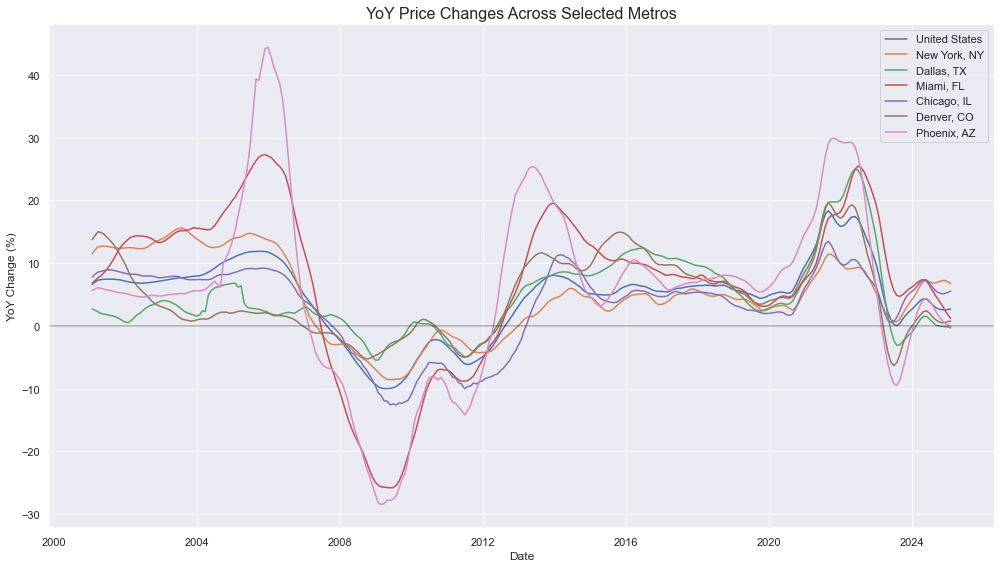


CURRENT MARKET STATE BY METRO
        Metro     Regime  YoY Change  Shift Probability Next Regime
United States Stagnation    2.678085                0.8   Expansion
 New York, NY  Expansion    6.745650                0.3 Speculative
   Dallas, TX Correction   -0.306278                0.1  Stagnation
    Miami, FL Stagnation    1.193200                0.1   Expansion
  Chicago, IL  Expansion    5.554852                0.3 Speculative
   Denver, CO Stagnation    0.765346                0.3   Expansion
  Phoenix, AZ Correction   -0.101605                0.1  Stagnation

INVESTMENT SIGNALS
United States: ACCUMULATE - Preparing for growth
  Current: Stagnation (YoY Change: 2.68%)
  Outlook: 0.80 probability of shift to Expansion
----------------------------------------------------------------------
New York, NY: HOLD
  Current: Expansion (YoY Change: 6.75%)
  Outlook: 0.30 probability of shift to Speculative
----------------------------------------------------------------------
Dallas, TX

In [15]:
# Metro-Level Dashboard and Decision Support
# Create a dashboard for comparing metros and generating investment signals

# Select a set of diverse metros to analyze
metro_list = [
    'United States',      # National benchmark
    'New York, NY',       # Large coastal
    'Dallas, TX',         # Fast-growing sunbelt
    'Miami, FL',          # Volatile market
    'Chicago, IL',        # Midwest
    'Denver, CO',         # Mountain west
    'Phoenix, AZ'         # Desert southwest
]

# Calculate market state for each metro
metro_states = {}
for metro in metro_list:
    if metro in metro_data['RegionName'].values:
        metro_states[metro] = classify_market_state(metro_data, metro)
        print(f"Processed {metro}")

# Create comparative visualizations
plt.figure(figsize=(14, 8))

# Plot YoY price changes for each metro
for metro, data in metro_states.items():
    plt.plot(data['date'], data['yoy_change'], label=metro)

plt.title('YoY Price Changes Across Selected Metros', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('YoY Change (%)', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a heatmap of current market states
current_data = []
for metro, data in metro_states.items():
    if not data.empty:
        current = data.iloc[-1]
        current_data.append({
            'Metro': metro,
            'Regime': current['rule_regime'],
            'YoY Change': current['yoy_change'],
            'Shift Probability': current['regime_shift_probability'],
            'Next Regime': current['next_likely_regime'],
            'Days in Regime': current['days_in_regime']
        })

current_df = pd.DataFrame(current_data)

# Create a summary table
print("\nCURRENT MARKET STATE BY METRO")
print("=" * 70)
print(current_df[['Metro', 'Regime', 'YoY Change', 'Shift Probability', 'Next Regime']].to_string(index=False))

# Create investment signals
print("\nINVESTMENT SIGNALS")
print("=" * 70)

for metro, data in metro_states.items():
    if not data.empty:
        current = data.iloc[-1]
        regime = current['rule_regime']
        shift_prob = current['regime_shift_probability']
        next_regime = current['next_likely_regime']
        
        signal = "HOLD"  # Default signal
        
        # Generate signals based on regime and transition probability
        if regime == "Correction" and shift_prob > 0.6:
            signal = "BUY - Likely near bottom"
        elif regime == "Expansion" and shift_prob < 0.3:
            signal = "BUY - Healthy growth phase"
        elif regime == "Bubble_Risk" or (regime == "Speculative" and shift_prob > 0.5):
            signal = "SELL - Potential bubble conditions"
        elif regime == "Stagnation" and next_regime == "Expansion":
            signal = "ACCUMULATE - Preparing for growth"
        elif regime == "Stagnation" and next_regime == "Correction":
            signal = "REDUCE - Potential downturn ahead"
            
        print(f"{metro}: {signal}")
        print(f"  Current: {regime} (YoY Change: {current['yoy_change']:.2f}%)")
        print(f"  Outlook: {shift_prob:.2f} probability of shift to {next_regime}")
        print("-" * 70)